<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-libraries" data-toc-modified-id="Load-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load libraries</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Create-a-data-generator" data-toc-modified-id="Create-a-data-generator-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Create a data generator</a></span></li><li><span><a href="#Train-model" data-toc-modified-id="Train-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Train model</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Evaluation</a></span></li></ul></div>

# Load libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import evaluation
import pandas as pd
import _pickle as cPickle

# Load data

In [2]:
data_dir = "./data/"  + "dataset/"

MFCC_LEN_LIM = 700
N_MFCC = 13

In [3]:
import _pickle as cPickle

with open(data_dir + "data_mfcc_for_generator.pkl", 'rb') as f:
    data_mfcc = cPickle.load(f)

In [4]:
audio_pairs_df = pd.read_csv("./data/audio_sentence_pairs_full.csv")
audio_pairs_df

,student_I_id,article_I_id,sentence_I_id,student_II_id,article_II_id,sentence_II_id
0,18021206_HoVanThep,9,15,18021206_HoVanThep,6,11
1,18021174_TranTrungThanh,4,13,17021242_PhamTuanHiep,4,13
2,18020370_NguyenManhDung,1,12,18020370_NguyenManhDung,1,33
3,18021027_LeThiPhuong,0,13,18021027_LeThiPhuong,2,6
4,17021340_ThieuMinhThinh,2,20,18020557_NguyenHuyHoang,2,20
...,...,...,...,...,...,...
999995,18020131_TranDucAnh,2,39,17021313_DinhCongPhan,2,39
999996,18020131_TranDucAnh,5,5,18020131_TranDucAnh,0,7
999997,18020370_NguyenManhDung,6,4,18020370_NguyenManhDung,7,29
999998,18020131_TranDucAnh,1,0,18020131_TranDucAnh,2,28


In [5]:
audio_pairs = audio_pairs_df.to_numpy()

In [6]:
def load_data(folds):
    X = []
    y = []
    for fold in folds:
        with open(data_dir + f"data_mfcc_{fold}.pkl", 'rb') as f:
            data_mfcc = cPickle.load(f)

        for i in range(len(data_mfcc['sentence_I'])):
            if data_mfcc['sentence_I'][i].shape[0] < MFCC_LEN_LIM:
                sentence_I = np.zeros((MFCC_LEN_LIM, N_MFCC), dtype=np.float32)
                sentence_I[-data_mfcc['sentence_I'][i].shape[0]:] = data_mfcc['sentence_I'][i]
            else:
                sentence_I = data_mfcc['sentence_I'][i]
                
            if data_mfcc['sentence_II'][i].shape[0] < MFCC_LEN_LIM:
                sentence_II = np.zeros((MFCC_LEN_LIM, N_MFCC), dtype=np.float32)
                sentence_II[-data_mfcc['sentence_II'][i].shape[0]:] = data_mfcc['sentence_II'][i]
            else:
                sentence_II = data_mfcc['sentence_II'][i]
            X.append([sentence_I, sentence_II])
            y.append(data_mfcc['same_speaker'][i])
    return np.array(X), np.array(y)

In [7]:
X_val, y_val = load_data(["val"])
X_val.shape

(10000, 2, 700, 13)

# Create a data generator

In [8]:
import numpy as np
import tensorflow as tf
import random

In [9]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, batch_size=32, shuffle=True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.swap = False
        
    def __len__(self):
        return int(np.floor(len(audio_pairs) / self.batch_size))
    
    def __getitem__(self, index):
        pairs = audio_pairs[index*self.batch_size:(index+1)*self.batch_size]
        X_1 = []
        X_2 = []
        y = []
        for pair in pairs:
            student_I_id, article_I_id, sentence_I_id = pair[0], pair[1], pair[2]
            student_II_id, article_II_id, sentence_II_id = pair[3], pair[4], pair[5]
            X_1.append(data_mfcc[student_I_id][article_I_id][sentence_I_id])
            X_2.append(data_mfcc[student_II_id][article_II_id][sentence_II_id])
            y.append(student_I_id == student_II_id)
        if not self.swap:
            return [np.array(X_1), np.array(X_2)], np.array(y)
        else:
            return [np.array(X_2), np.array(X_1)], np.array(y)
    
    def on_epoch_end(self):
        random.shuffle(audio_pairs)
        self.swap = not self.swap

In [10]:
# def data_generator(batch_size=32, shuffle=True):
#     while True:
#         if shuffle:
#             random.shuffle(audio_pairs)
            
#         for index in range(int(np.floor(len(audio_pairs) / batch_size))):
#             pairs = audio_pairs[index*batch_size:(index+1)*batch_size]
#             X_1 = []
#             X_2 = []
#             y = []
#             for pair in pairs:
#                 student_I_id, article_I_id, sentence_I_id = pair[0], pair[1], pair[2]
#                 student_II_id, article_II_id, sentence_II_id = pair[3], pair[4], pair[5]
#                 X_1.append(data_mfcc[student_I_id][article_I_id][sentence_I_id])
#                 X_2.append(data_mfcc[student_II_id][article_II_id][sentence_II_id])
#                 y.append(student_I_id == student_II_id)
#             yield [np.array(X_1), np.array(X_2)], np.array(y)

# Train model

In [10]:
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

class GRU_GRU:
    def __init__(self, num_features, encoder_shape=64, learning_rate=0.001):
        self.num_features = num_features
        self.encoder_shape = encoder_shape
        self.learning_rate = learning_rate
        
        self.classifier = self.build_classifier()
    
    def build_classifier(self):
        input_1 = Input(shape = (None, self.num_features))
        input_2 = Input(shape = (None, self.num_features))
        
        encoder_1 = GRU(self.encoder_shape, return_sequences=True)(input_1)
        encoder_11 = GRU(self.encoder_shape)(encoder_1)
            
        encoder_2 = GRU(self.encoder_shape, return_sequences=True)(input_2)
        encoder_22 = GRU(self.encoder_shape)(encoder_2)
            
        merge = concatenate([encoder_11, encoder_22], axis = 1)
        
        dense_1 = Dense(64, activation = "relu", kernel_initializer='glorot_uniform')(merge)
        dropout_1 = Dropout(0.3)(dense_1)
        dense_2 = Dense(1, activation ="sigmoid", kernel_initializer='glorot_uniform')(dropout_1)

        model = Model(inputs = [input_1, input_2], outputs = dense_2)
        model.compile(optimizer = Adam(self.learning_rate), loss = "binary_crossentropy", metrics = ["acc"])

        model.summary()
        return model
    
    def save_weights(self):
        self.classifier.save_weights('saved_model/gru_gru_weights.h5')
        
    def load_weights(self):
        self.classifier.load_weights('saved_model/gru_gru_weights.h5')
            
    def fit(self, generator, epochs=50, early_stopping_rounds=7, X_val=None, y_val=None):
        model_dir = './checkpoints/'
        callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=early_stopping_rounds,
                                             monitor='val_acc',
                                             restore_best_weights=True),
            tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(model_dir, "weights-epoch{epoch:02d}-loss{val_loss:.2f}-acc{val_acc:.2f}.h5"),
                                              save_weights_only=True,
                                              monitor='val_acc',
                                              mode='max',
                                              save_best_only=True)
            ]
        
        history = self.classifier.fit(generator,
                                      epochs=epochs,
                                      verbose=1,
                                      callbacks=callbacks,
                                      validation_data=([X_val[:,0], X_val[:,1]], y_val),
                                      use_multiprocessing=False,
                                      workers=6
                                     )
        return history
    
    def predict(self, X):
        return self.predict_proba(X) >= 0.5
    
    def predict_proba(self, X):
        y = self.classifier.predict([X[:,0], X[:,1]])
        return y

In [11]:
model = GRU_GRU(num_features=N_MFCC)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 13)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 13)]   0                                            
__________________________________________________________________________________________________
gru (GRU)                       (None, None, 64)     15168       input_1[0][0]                    
__________________________________________________________________________________________________
gru_2 (GRU)                     (None, None, 64)     15168       input_2[0][0]                    
_______________________________________________________________________________________

In [12]:
train_generator = DataGenerator(batch_size=64)
#train_generator = tf.data.Dataset.from_generator(data_generator, (np.float32, np.int32))

model.fit(train_generator, epochs=50, early_stopping_rounds=7, X_val=X_val, y_val=y_val)

Epoch 1/50
15625/15625 [==============================] - 2346s 150ms/step - loss: 0.2146 - acc: 0.9173 - val_loss: 0.7078 - val_acc: 0.8209
Epoch 2/50
15625/15625 [==============================] - 1727s 111ms/step - loss: 0.0854 - acc: 0.9720 - val_loss: 1.0147 - val_acc: 0.8231
Epoch 3/50
15625/15625 [==============================] - 1711s 109ms/step - loss: 0.0404 - acc: 0.9874 - val_loss: 1.1862 - val_acc: 0.8329
Epoch 4/50
15625/15625 [==============================] - 3247s 208ms/step - loss: 0.0191 - acc: 0.9943 - val_loss: 1.3640 - val_acc: 0.8280
Epoch 5/50
    1/15625 [..............................] - ETA: 0s - loss: 0.0022 - acc: 1.0000

KeyboardInterrupt: 

In [18]:
model.save_weights()

# Evaluation

In [ ]:
model.load_weights()

In [13]:
X_test, y_test = load_data(["test"])

In [14]:
y_pred = model.predict(X_test)

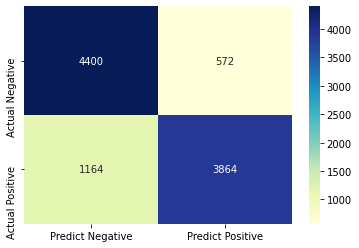

In [15]:
evaluation.plot_confusion_matrix(y_test, y_pred)

In [16]:
evaluation.print_classification_report(y_test, y_pred)

Classification report:
               precision    recall  f1-score   support

       False       0.79      0.88      0.84      4972
        True       0.87      0.77      0.82      5028

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



In [17]:
evaluation.get_f1_score(y_test, y_pred, average='macro')

0.8258998171386467